## Step 2. 얼굴 검출 & 랜드마크 검출 하기
- 오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

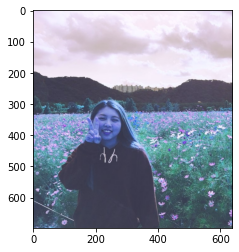

In [2]:
# 준비한 이미지 불러오기 
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 가져오기, 컬러가 Default, cv2.IMREAD_GRAYSCALE 넣어주면 흑백으로 준비 
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

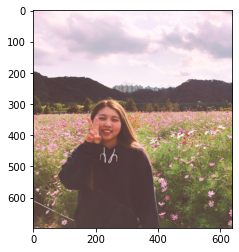

In [3]:
# opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용 -> RGB로 색깔 보정 처리, 원래 색상으로 보임
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### detector 선언  dlib 활용 그중에서 정면얼굴 검출기 

In [4]:
detector_hog = dlib.get_frontal_face_detector()  

# bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

rectangles[[(195, 325) (285, 415)]]


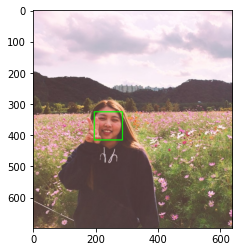

In [5]:
# 찾은 얼굴을 화면에 출력하기 
print(dlib_rects)   

# LINE_4 = 4, LINE_8 = 8, LINE_AA = 16
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 저장한 landmark 모델 불러오기 

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

### Dlib landmark 68개 찾고 좌표 저장하기

In [7]:
list_landmarks = []

# 얼굴 전체 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
# print(list_landmarks)

68


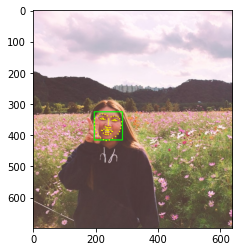

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)   # 두께가 -1 이므로 색상 채우기
                                                            # 노란색 점
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
- 고양이 수염이 적용 될 위치를 landmark를 사용해서 계산

### 스티커 붙일 좌표 확인하기 

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코끝 index는 33 위치는 (240, 368)
    x = landmark[33][0]   # x,y 좌표는 변함 없으므로 그대로 사용
    y = landmark[33][1]    
    w = h = dlib_rect.width() # 얼굴 영역 박스의 폭과 높이 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(238, 376)
(x,y) : (238,376)
(w,h) : (91,91)


(91, 91, 3)


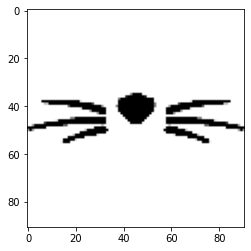

In [10]:
# 스티커 그림 불러와서 resize 시킴
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

In [11]:
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (193,331)


## Step 4. 스티커 적용하기
- 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.
- 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. 

In [12]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (193,331)


In [13]:
# np.where 예시
A = np.array([1,2,3,4,5,6])
# 3보다 큰 값의 '위치'를 찾고 
# np.where(A>3)     #(array([3, 4, 5]),) 인덱스 3,4,5번 위치 

# 3보다 크면 100, 아니면 0으로 바꾸기 
np.where(A>3, 100, 0)

array([  0,   0,   0, 100, 100, 100])

원본 이미지에 고양이 수염이 그려지는 것은 그냥 붙여 넣는 것이 아님
원본 이미지 픽셀값을 -> 고양이 수염 픽셀값으로 바꿔서 이미지가 겹쳐지는 것처럼 보임
고양이 수염 전체 이미지(img_sticker) 픽셀을 다 사용하면 원본 이미지가 가려짐
* 고양이 수염 그림 중 픽셀값이 검정색이면 고양이 수염으로 남기고(img_sticker), 픽셀값이 검정색이 아니면 원본 이미지(sticker_area)로 나타내기 

In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

# img_sticker가 검정색이면 img_sticker로 바꿔라, 검정색이 아닌건 sticker_area(원본)로 나타내라

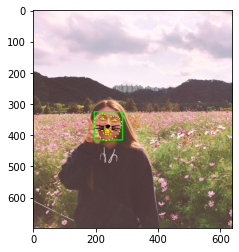

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

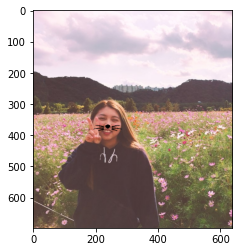

In [16]:
# img_bgr 원본파일에 고양이 수염 스티커를 넣기
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 
- 얼굴 각도에 따라 스티커도 같이 돌아가면서 작동이 되어야 함 
- 옆으로 돌아간 사진을 사용하면 list_landmarks를 할 때 범위에서 벗어나는 에러가 발생
- 멀리서 촬영하면 얼굴 검출 할 때 얼굴 박스도 작아지고 그에 따른 스티커 박스는 더 작아지므로 